### Sentiment Analysis Using Logistic Regression and Baseline Model

In [3]:
# load in the clean data
import pandas as pd
import numpy as np  

from src.paths import TRANSFORMED_DATA_DIR

In [4]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'cleaned_sentiments.parquet')
df.head()

,recommended,cleaned
0,1,Very good flight following an equally good fli...
1,1,An hours delay due to late arrival of the inco...
2,0,I booked through BA because Loganair dont have...
3,0,British airways lost bags in LHR then found th...
4,0,The check in process and reward loyalty progra...


In [5]:
# distribution of recommended
df['recommended'].value_counts(normalize=True)

recommended
0    0.626605
1    0.373395
Name: proportion, dtype: float64

In [6]:
# libraries needed for our sentiment analysis
import nltk
from nltk import word_tokenize

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [9]:
from sklearn.model_selection import train_test_split

# split the data
X = df['cleaned']
y = df['recommended']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Baseline Model

Our first model will be a very simple baseline model that just predicts the most common recommendation which, in this case, is a negative sentiment since a review only recommends British Airways roughly 63% of the time.

In [8]:
class BaselineModelNotRecommend:
    '''Predict a negative sentiment'''
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        # this model is very simple and does nothing 
        pass

    def predict(self, X_test: pd.DataFrame) -> np.array:
        # just a 0 for the entire length of X_test
        return np.zeros(len(X_test))

#### Use TF-IDF Vectorizer

We will be using **TFIDFVectorizer** with the default parameters since the reviews we looked at were not very messy. The default pattern for the tokenizer is r'(?u)\b\w\w+\b' which matches any alphabetical/numerical characters more than length=1 and underscores. This also ignores punctuation and symbols even though we already removed them.

In [12]:
# tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize count vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# fit transform the training data
X_train_vec = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
X_test_vec = tfidf_vectorizer.transform(X_test)

In [11]:
# metrics and predictions
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# make predictions with baseline model
baseline_model = BaselineModelNotRecommend()

# fit
baseline_model.fit(X_train, y_train)

# predict
y_pred_baseline = baseline_model.predict(X_test)

# classification report
print(classification_report(y_test, y_pred_baseline, zero_division=0))


              precision    recall  f1-score   support

           0       0.65      1.00      0.78       503
           1       0.00      0.00      0.00       276

    accuracy                           0.65       779
   macro avg       0.32      0.50      0.39       779
weighted avg       0.42      0.65      0.51       779



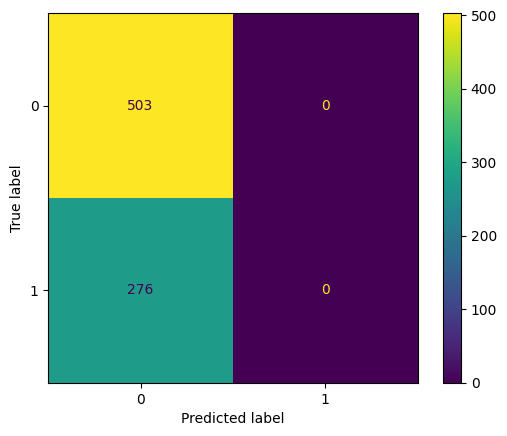

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_baseline)